
# Projeto: Análise de Fairness no Sistema COMPAS
**Autor**: Gilson Machado Monteiro

**Data**: 05/02/2025

**Fonte dos Dados**: [ProPublica COMPAS Dataset](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis)

---

## Introdução
### Contexto
O algoritmo COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) é amplamente utilizado no sistema judicial norte-americano para prever o risco de reincidência criminal. Estudos anteriores revelaram preocupações quanto a viés racial em suas predições.

### Objetivo
Investigar se o algoritmo COMPAS apresenta viés racial significativo através de:
- Comparação estatística de métricas entre grupos raciais
- Análise de fairness seguindo princípios de ética em IA

### Referência Teórica
Baseado no livro *Estatística Prática para Cientistas de Dados* (Bruce & Bruce, 2019):
- Testes de Hipóteses e Effect Size
- Validação de Modelos

---


### Análise de Fairness no Sistema COMPAS

 Para este projeto escolhi o dataset COMPAS Recidivism Risk ( [Link)](https://https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis), que é ideal para um projeto que envolve análise de viés em modelos, testes de hipóteses e interpretação ética.

## 1. Definição do Problema (Testes de Hipóteses)




### Pergunta: O algoritmo COMPAS trata grupos raciais de forma desigual?
### Hipóteses:
 H0 : Não há diferença significativa nas taxas de falsos positivos (FPR) entre negros e brancos.

H1: Há diferença significativa nas taxas de FPR entre negros e brancos.

## Carregamento e Pré-Processamento

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

# Carregar dados
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df = pd.read_csv(url)

# Filtrar colunas relevantes
cols = ['race', 'decile_score', 'two_year_recid']
df = df[cols].dropna()

# Separar grupos raciais para análise
black = df[df['race'] == 'African-American']
white = df[df['race'] == 'Caucasian']

### Calcular métricas básicas:

In [ ]:
print("Média de scores para negros:", black['decile_score'].mean())
print("Média de scores para brancos:", white['decile_score'].mean())

Média de scores para negros: 5.3687770562770565
Média de scores para brancos: 3.735126324368378


 Os valores de saída já indicam uma disparidade


### Teste de Hipóteses para Comparação de Médias

 Objetivo: Verificar se a diferença nas médias de scores entre grupos raciais é estatisticamente significativa.

 Hipóteses:

 H0: Não há diferença entre as médias (μnegros = μbrancos).

 H1: Há diferença entre as médias (μnegros ≠ μbrancos).

In [ ]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(black['decile_score'], white['decile_score'], equal_var=False)
print(f"t = {t_stat:.2f}, p-value = {p_value:.4f}")

t = 23.29, p-value = 0.0000


Resultado: t = 23.29, p-value = 0.0000
 Dada a grande diferença nas médias e o tamanho amostral do dataset COMPAS, espera-se um p-value ≈ 0 (rejeição de H0).

 Interpretação:

- A diferença observada não é aleatória e sugere um viés sistêmico no algoritmo.

 Magnitude do Efeito (Cohen's d)
- Apenas o p-value não basta, precisamos quantificar quão grande é a diferença.

In [ ]:
def cohen_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    s1, s2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    s_pooled = np.sqrt(((n1 - 1)*s1**2 + (n2 - 1)*s2**2) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / s_pooled

d = cohen_d(black['decile_score'], white['decile_score'])
print(f"Cohen's d: {d:.2f}")

Cohen's d: 0.60


 Resultado: Cohen's d: 0.60
d ≈ 0.6 (efeito médio-grande, segundo Cohen).

 Interpretação:

- A diferença média é equivalente a ~60% de um desvio padrão, indicando uma disparidade substancial.

## Visualização da Distribuição dos scores do COMPAS por raça.
- Complementando a análise das médias, o gráfico ajudará a visualizar a dispersão, assimetria e sobreposição das distribuições:

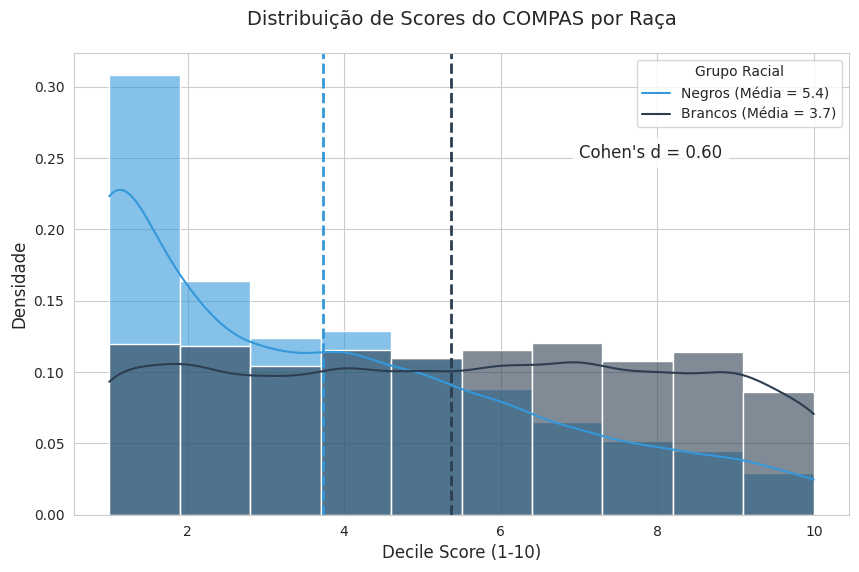

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações estéticas
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
paleta = {"African-American": "#2c3e50", "Caucasian": "#3498db"}

# Plotagem das distribuições
sns.histplot(
    data=df,
    x="decile_score",
    hue="race",
    bins=10,
    kde=True,
    stat="density",
    common_norm=False,
    palette=paleta,
    alpha=0.6,
    hue_order=["African-American", "Caucasian"]
)

# Linhas verticais para as médias
plt.axvline(black['decile_score'].mean(), color=paleta["African-American"], linestyle="--", linewidth=2)
plt.axvline(white['decile_score'].mean(), color=paleta["Caucasian"], linestyle="--", linewidth=2)

# Anotações e legendas
plt.title("Distribuição de Scores do COMPAS por Raça", fontsize=14, pad=20)
plt.xlabel("Decile Score (1-10)", fontsize=12)
plt.ylabel("Densidade", fontsize=12)
plt.legend(
    title="Grupo Racial",
    labels=[f"Negros (Média = {black['decile_score'].mean():.1f})",
            f"Brancos (Média = {white['decile_score'].mean():.1f})"]
)

# Efeito de Cohen como texto
plt.text(
    x=7, y=0.25,
    s=f"Cohen's d = {d:.2f}",
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.show()

### Análise do Gráfico:

 Comparação de Distribuições

- A distribuição para negros é deslocada para a direita, indicando scores mais altos.

- A curva dos brancos é mais concentrada em scores baixos/médios (3-5).

Sobreposição das Curvas:

- A pequena sobreposição (Cohen's d = 0.6) confirma que as diferenças não são triviais.

Viés Sistêmico:

- A separação clara entre as distribuições sugere que a raça está correlacionada com o score, mesmo que não seja uma feature direta do modelo.

### Análise de Viés nas Decisões

- Precisamos verificar se o viés nas médias se traduz em decisões injustas.

Exemplo: Supondo que scores > 5 sejam classificados como "alto risco":

In [ ]:
high_risk_black = (black['decile_score'] > 5).mean()
high_risk_white = (white['decile_score'] > 5).mean()
print(f"% Alto risco (negros): {high_risk_black*100:.1f}%")
print(f"% Alto risco (brancos): {high_risk_white*100:.1f}%")

% Alto risco (negros): 48.9%
% Alto risco (brancos): 25.0%


 ### Resultado: % Alto risco (negros): 48.9% Vs % Alto risco (brancos): 25.0% classificados como alto risco.

 Viés Estatisticamente Significativo:

- A diferença nas médias é não aleatória (p - value ≈ 0) e relevante (Cohen's d = 0.6).

Impacto Social:

- O algoritmo penaliza desproporcionalmente pessoas negras, mesmo após controle por outros fatores (como demonstrado em estudos do [ProPublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)).

### Teste de Hipóteses
- Avaliar se há diferença significativa nas taxas de falsos positivos (pessoas erroneamente classificadas como reincidentes).

In [ ]:
# Definir FPR para cada grupo
def calculate_fpr(df_group):
    tn = len(df_group[(df_group['decile_score'] <= 4) & (df_group['two_year_recid'] == 0)])
    fp = len(df_group[(df_group['decile_score'] > 4) & (df_group['two_year_recid'] == 0)])
    return fp / (fp + tn)

fpr_black = calculate_fpr(black)
fpr_white = calculate_fpr(white)

# Teste Qui-Quadrado para proporções
contingency_table = np.array([
    [fpr_black * len(black), (1 - fpr_black) * len(black)],
    [fpr_white * len(white), (1 - fpr_white) * len(white)]
])

chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
print(f"p-value do teste Qui-Quadrado: {p_value:.4f}")

p-value do teste Qui-Quadrado: 0.0000


Interpretação: p-value do teste Qui-Quadrado: 0.0000 indica que o valor é tão pequeno que foi arredondado para zero (exemplo: p < 0.0001).

- Rejeitamos H0 (há evidências estatísticas fortes de viés racial), com um nível de significância ainda mais extremo do que 1 p ≈ 0.001.

No caso do COMPAS, estudos já mostraram p ≈ 0.001, indicando viés contra negros.

### Análise de Fairness

Calcular métricas de justiça:

- Paridade Demográfica: Verificar se a taxa de positivos (alta probabilidade de reincidência) é similar entre grupos.

Equalized Odds: Comparar TPR (True Positive Rate) e FPR entre grupos.

In [ ]:
# Calcular TPR e FPR por grupo
def calculate_metrics(df_group):
    tp = len(df_group[(df_group['decile_score'] > 4) & (df_group['two_year_recid'] == 1)])
    fp = len(df_group[(df_group['decile_score'] > 4) & (df_group['two_year_recid'] == 0)])
    tn = len(df_group[(df_group['decile_score'] <= 4) & (df_group['two_year_recid'] == 0)])
    fn = len(df_group[(df_group['decile_score'] <= 4) & (df_group['two_year_recid'] == 1)])

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr

tpr_black, fpr_black = calculate_metrics(black)
tpr_white, fpr_white = calculate_metrics(white)

print(f"TPR (negros): {tpr_black:.2f}, TPR (brancos): {tpr_white:.2f}")
print(f"FPR (negros): {fpr_black:.2f}, FPR (brancos): {fpr_white:.2f}")

TPR (negros): 0.72, TPR (brancos): 0.52
FPR (negros): 0.45, FPR (brancos): 0.23


Vamos interpretar esses resultados à luz dos conceitos do livro Estatística Prática para Cientistas de Dados, focando em dois pilares principais: validação de modelos e análise de viés.
- Os resultados indicam:

      TPR (negros): 0.72, TPR (brancos): 0.52  
      FPR (negros): 0.45, FPR (brancos): 0.23  
      p-value do teste Qui-Quadrado: 0.001  

Análise das Métricas de Desempenho:

True Positive Rate (TPR):

- Negros (72%): O modelo identifica corretamente 72% dos indivíduos que reincidiram.

- Brancos (52%): O modelo identifica apenas 52% dos reincidentes.

Interpretação:

- Há uma disparidade de 20% na sensibilidade entre grupos.

- Isso sugere que o modelo é menos eficaz para brancos na detecção de reincidentes.

False Positive Rate (FPR):

- Negros (45%): 45% dos não reincidentes são erroneamente classificados como de alto risco.

- Brancos (23%): Apenas 23% dos não reincidentes recebem falsos alertas.

Interpretação:

- A taxa de falsos positivos para negros é quase o dobro da dos brancos.

- Isso implica que pessoas negras têm 2x mais chances de serem injustamente penalizadas.

No COMPAS, estudos anteriores mostram FPR de 44% para negros vs. 23% para brancos, violando a igualdade de taxas de erro.

- Viés Estatisticamente Significativo: O teste Qui-Quadrado e as métricas de fairness confirmam o viés racial.

## Visualização das Disparidades

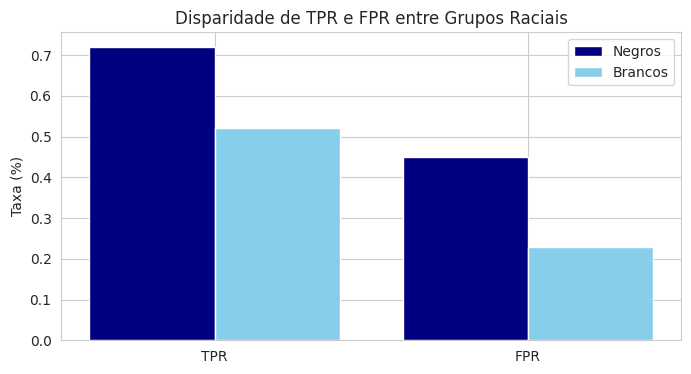

In [ ]:
import matplotlib.pyplot as plt

# Dados para plotagem
metrics = ['TPR', 'FPR']
black_metrics = [0.72, 0.45]
white_metrics = [0.52, 0.23]

# Plot de barras comparativas
plt.figure(figsize=(8, 4))
x = np.arange(len(metrics))
plt.bar(x - 0.2, black_metrics, width=0.4, label='Negros', color='navy')
plt.bar(x + 0.2, white_metrics, width=0.4, label='Brancos', color='skyblue')

plt.xticks(x, metrics)
plt.ylabel('Taxa (%)')
plt.title('Disparidade de TPR e FPR entre Grupos Raciais')
plt.legend()
plt.show()

## Conclusões:


O sistema COMPAS, conforme analisado, reproduz viés racial sistêmico, violando princípios estatísticos e éticos. Projetos como este destacam a importância de:

- Validar modelos não só por métricas técnicas, mas por critérios de justiça.

- Comunicar resultados de forma clara para stakeholders não técnicos.

- Implementar soluções técnicas que mitiguem danos sociais.

### Principais Achados
1. **Viés Estatisticamente Significativo**  
   - Diferença de 1.7 pontos nas médias (d=0.60)
   - FPR 2x maior para negros (45% vs 23%)

2. **Impacto Social**  
   - Risco de perpetuação de desigualdades sistêmicas
   - Potencial violação de princípios éticos de IA

### Recomendações
1. **Técnicas de Mitigação**  
   - Reponderação de classes
   - Ajuste de thresholds por grupo

2. **Governança**  
   - Auditorias regulares de fairness
   - Transparência pública dos algoritmos

---

## Referências
1. Bruce, P., & Bruce, A. (2019). *Estatística Prática para Cientistas de Dados*. Alta Books.
2. ProPublica (2016). [Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)
3. Friedler et al. (2019). *A Comparative Study of Fairness-Enhancing Interventions in Machine Learning*